## Create A Custom Container for a Vertex AI Workbench Managed Notebook

- Base Image from Deep Learning Containers: https://cloud.google.com/deep-learning-containers/docs/choosing-container#deciding
- Add a custom container to managed notebook instance: https://cloud.google.com/vertex-ai/docs/workbench/managed/custom-container

In [10]:
import json

In [15]:
PROJECT_ID = 'statmike-demo3'
NOTEBOOK = 'custom_notebook'
REGION = 'us-central1'
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/sklearn-cpu.0-23'

In [3]:
#BUCKET = PROJECT_ID
#URI = f"gs://{BUCKET}/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [4]:
!rm -rf {DIR}
!mkdir -p {DIR}

In [5]:
!mkdir -p {DIR}/scripts

test here first

In [56]:
!sudo apt-get install google-drive-ocamlfuse

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package google-drive-ocamlfuse


In [59]:
!sudo add-apt-repository --yes ppa:alessandro-strada/ppa

gpg: keybox '/tmp/tmp3c13fz84/pubring.gpg' created
gpg: /tmp/tmp3c13fz84/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
gpg: no valid OpenPGP data found.


In [60]:
!sudo apt-get update

Hit:2 http://packages.cloud.google.com/apt cloud-sdk-buster InRelease          
Hit:3 http://security.debian.org/debian-security buster/updates InRelease      
Hit:4 http://packages.cloud.google.com/apt google-cloud-packages-archive-keyring-buster InRelease
Hit:5 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Hit:6 http://packages.cloud.google.com/apt gcsfuse-buster InRelease            
Hit:7 http://deb.debian.org/debian buster InRelease                            
Hit:1 https://packages.cloud.google.com/apt kubernetes-xenial InRelease        
Hit:8 http://packages.cloud.google.com/apt google-compute-engine-buster-stable InRelease
Get:9 https://download.docker.com/linux/debian buster InRelease [54.0 kB]      
Get:10 https://nvidia.github.io/libnvidia-container/stable/debian10/amd64  InRelease [1484 B]
Hit:11 http://deb.debian.org/debian buster-updates InRelease                   
Hit:12 http://deb.debian.org/debian buster-backports InRelease                 

In [58]:
!sudo apt-get install google-drive-ocamlfuse

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package google-drive-ocamlfuse


In [ ]:
!dune build @install

In [ ]:
!dune install

In [7]:
%%writefile {DIR}/scripts/install_google_drive.sh
sudo apt install -y opam

sudo apt install -y libcurl4-gnutls-dev libfuse-dev libgmp-dev libsqlite3-dev m4 zlib1g-dev # dependencies for google-drive-ocamlfuse
sudo apt-get install -y fuse
sudo apt-get install -y xdg-utils --fix-missing
sudo apt-get install -y xdg-utils --fix-missing
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
sudo apt install -y ./google-chrome-stable_current_amd64.deb
sudo apt autoremove -y
sudo apt-get install -y chromium

sudo apt-get install opam ocaml make fuse camlp4-extra build-essential pkg-config

opam init
eval `opam config env`
opam update
opam install depext

opam init --yes
eval `opam config env` # set needed environment variables
opam update --yes
opam install depext --yes
opam depext google-drive-ocamlfuse --yes
opam install google-drive-ocamlfuse --yes
sudo apt-get install lynx --yes

sudo mkdir -p ~/gdrive
sudo chmod 777 ~/gdrive

Writing temp/custom_notebook/scripts/install_google_drive.sh


In [11]:
services = !gcloud services list --format="json" --available --filter=name:artifactregistry.googleapis.com
services = json.loads("".join(services))

if (services[0]['config']['name'] == 'artifactregistry.googleapis.com') & (services[0]['state'] == 'ENABLED'):
    print(f"Artifact Registry is Enabled for This Project: {PROJECT_ID}")
else:
    print(f"Enabeling Artifact Registry for this Project: {PROJECT_ID}")
    !gcloud services enable artifactregistry.googleapis.com

Artifact Registry is Enabled for This Project: statmike-demo3


In [12]:
repositories = !gcloud artifacts repositories list --format="json" --filter=REPOSITORY:{PROJECT_ID}
repositories = json.loads("".join(repositories[2:]))

if len(repositories) > 0:
    print(f'There is already a repository named {PROJECT_ID}')
else:
    print(f'Creating a repository named {PROJECT_ID}')
    !gcloud  artifacts repositories create {PROJECT_ID} --repository-format=docker --location={REGION} --description="Vertex AI Training Custom Containers"

There is already a repository named statmike-demo3


In [13]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: {REGION}-docker.pkg.dev
gcloud credential helpers already registered correctly.


In [16]:
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}/{NOTEBOOK}:latest"
IMAGE_URI

'us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/custom_notebook:latest'

In [40]:
dockerfile = f"""
FROM {BASE_IMAGE}
RUN mkdir -p /scripts
COPY install_google_drive.sh /scripts
WORKDIR /scripts
RUN chmod +x install_google_drive.sh
RUN ./install_google_drive.sh
""".strip()
with open(f'{DIR}/scripts/Dockerfile', 'w') as f:
    f.write(dockerfile)

In [41]:
!docker build {DIR}/scripts/. -t $IMAGE_URI

Sending build context to Docker daemon   5.12kB
Step 1/6 : FROM gcr.io/deeplearning-platform-release/sklearn-cpu.0-23
 ---> 73bbcb0663a7
Step 2/6 : RUN mkdir -p /scripts
 ---> Running in 7f266c65d866
Removing intermediate container 7f266c65d866
 ---> f1dc7badcbb2
Step 3/6 : COPY install_google_drive.sh /scripts
 ---> 6e7fb5c8b4d4
Step 4/6 : WORKDIR /scripts
 ---> Running in 5ecf90cef488
Removing intermediate container 5ecf90cef488
 ---> 32a6f20d9fb9
Step 5/6 : RUN chmod +x install_google_drive.sh
 ---> Running in d9e5acf425a4
Removing intermediate container d9e5acf425a4
 ---> ab2a82464d39
Step 6/6 : RUN ./install_google_drive.sh
 ---> Running in c6f1b8eaf07d


Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package opam


Reading package lists...
Building dependency tree...
Reading state information...
Package libcurl4-gnutls-dev is not available, but is referred to by another package.
This may mean that the package is missing, has 

In [42]:
!docker push $IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/custom_notebook]

c56c4e26: Preparing 
40823836: Preparing 
be6e4f8b: Preparing 
cd6c31be: Preparing 
4f8407f3: Preparing 
368e27aa: Preparing 
dd2b9e38: Preparing 
e29d8d24: Preparing 
95a574c8: Preparing 
10151b48: Preparing 
c089358e: Preparing 
9b36546a: Preparing 
82ce8d0b: Preparing 
467ac3a5: Preparing 
91c31559: Preparing 
ae11254c: Preparing 
2bcbe281: Preparing 
4c112e39: Preparing 
048fd290: Preparing 
bf18a086: Preparing 
7a45d8d8: Preparing 
6651fb01: Preparing 
d5cafaa0: Preparing 
56c4e26: Pushed    87.1MB/87.09MBlatest: digest: sha256:2c3d044c5f4cbd720619c31a04ce4c7c0c996f084dd9d7e2198fd5182fbedd1d size: 5332


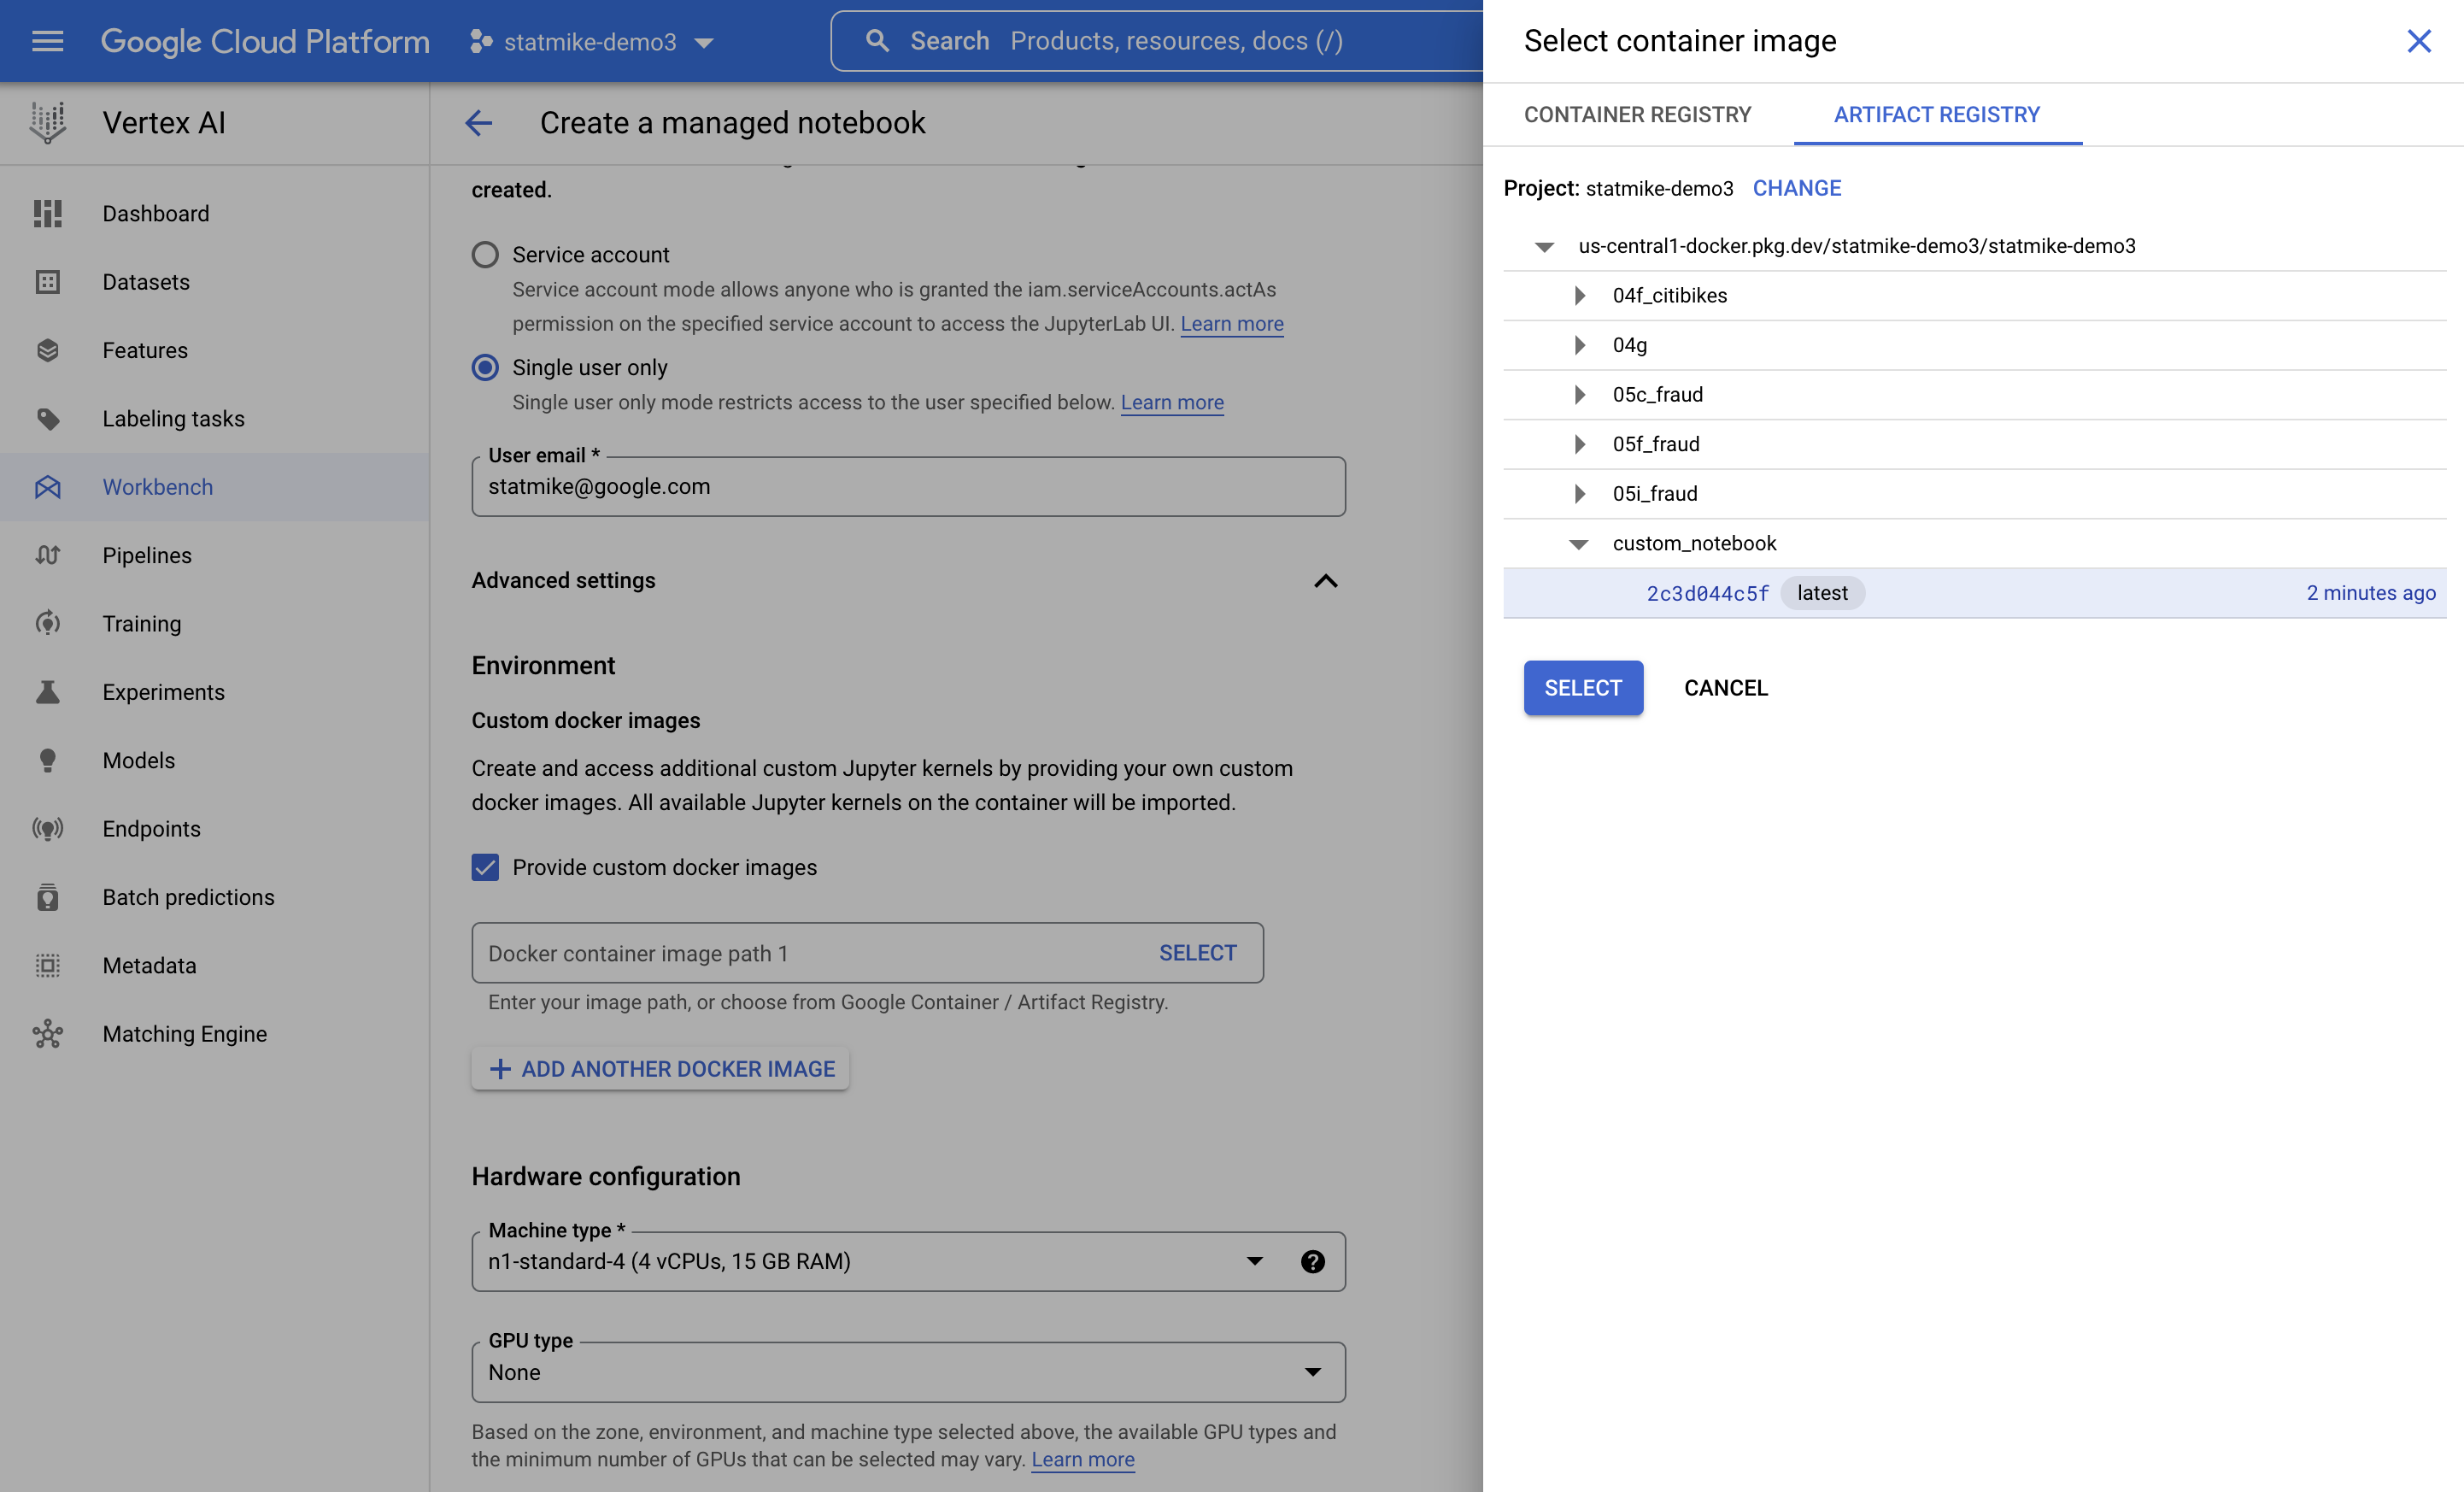

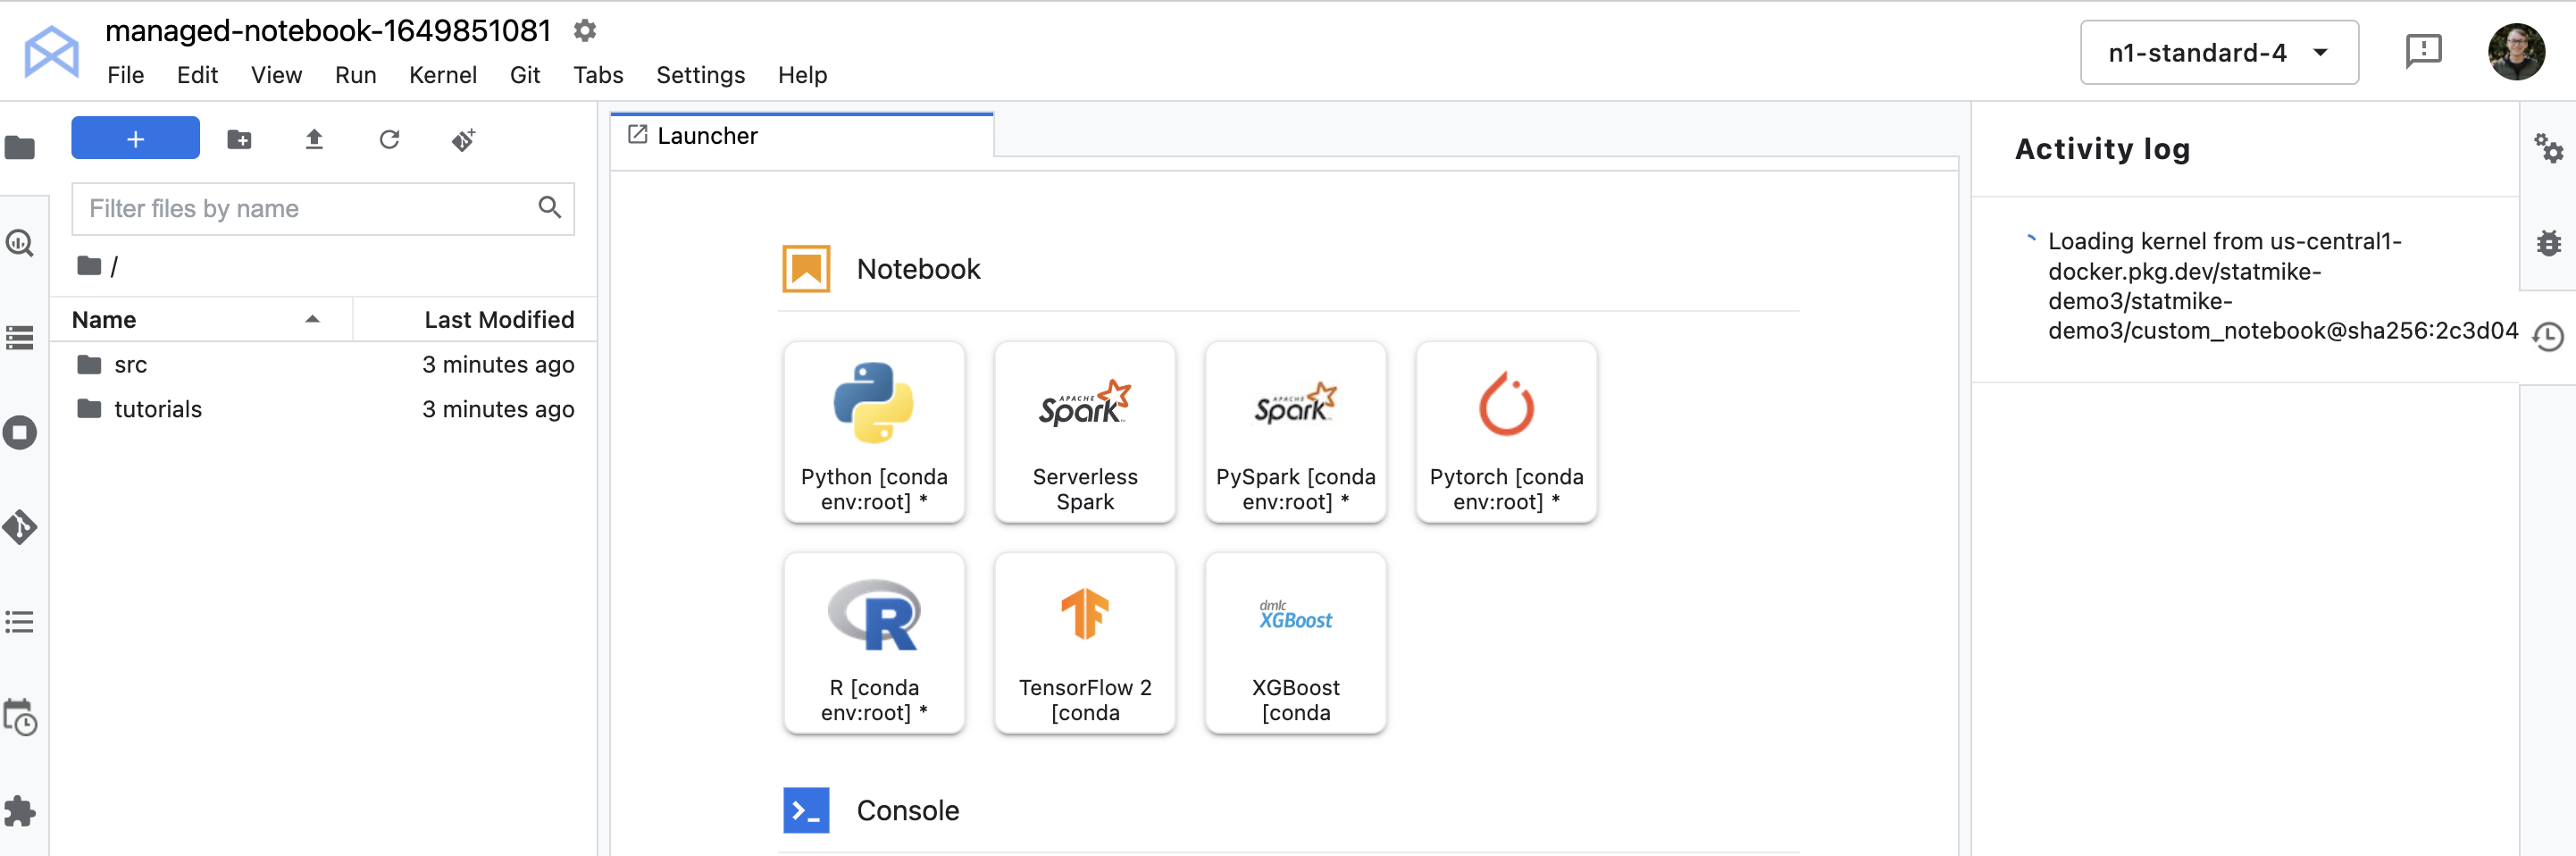

The activity log loading circle went for a very long time - maybe 45 minutes